In [ ]:
# Check if the code is running in a Colab environment
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

    # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive


In [ ]:
# install spacy
if 'google.colab' in str(get_ipython()):
    !pip install -U spacy -qq

In [ ]:
import spacy
from pathlib import Path
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(base_path + '/Twitter Sentiment Analysis/training.1600000.processed.noemoticon.csv', encoding = 'latin',header=None)

df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

In [ ]:
# check the models we have dowloaded in spacy folder
!python -m spacy download en_core_web_sm -qq

# We will load the model -en_core_web_sm
nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
stopwords = {"the", "to", ".", "i", "?", "!","&",",",";","#","@","%","^","-",":","'",'"',"`","'s","s'"}

In [ ]:
import ast
file_path = '/content/drive/MyDrive/Colab Notebooks/Twitter Sentiment Analysis/training_processed_1.6M.csv'

if os.path.exists(file_path):
  # Load the preprocessed CSV file
  df = pd.read_csv(file_path,encoding = 'utf-8')
  df['tokens'] = df['tokens'].apply(ast.literal_eval)
  print("Loaded preprocessed data from CSV.")

else:
  from tqdm.notebook import tqdm

  # initialize an empty list to store tokens
  tokens_master = []

  # process multiple documents in parallel using the spaCy NLP library
  # tqdm requires you to pass a total argument to estimate progress
  total_docs = len(df.text)  # Total number of documents to process
  batch_size = 5000

  # Wrap the pipe in tqdm to show a progress bar
  for doc in tqdm(nlp.pipe(df.text, batch_size=batch_size, n_process=90), total=total_docs):
      # extract text of each token in the document and create a list of tokens
      tokens = [token.lemma_ for token in doc if not token.like_url and not token.like_email and not (token.text in stopwords)]
      # add the list of tokens to the tokens_master list
      tokens_master.append(tokens)

  # add the tokens to the df dataframe as a new column 'tokens'
  df['tokens'] = tokens_master

  file_path = '/content/drive/MyDrive/Colab Notebooks/Twitter Sentiment Analysis/training_processed_1.6M.csv'
  df.to_csv(file_path, encoding = 'utf-8')
  print("Saved preprocessed data to CSV.")

Loaded preprocessed data from CSV.


count    1.600000e+06
mean     1.339189e+01
std      7.098691e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      1.730000e+02
Name: token_length, dtype: float64


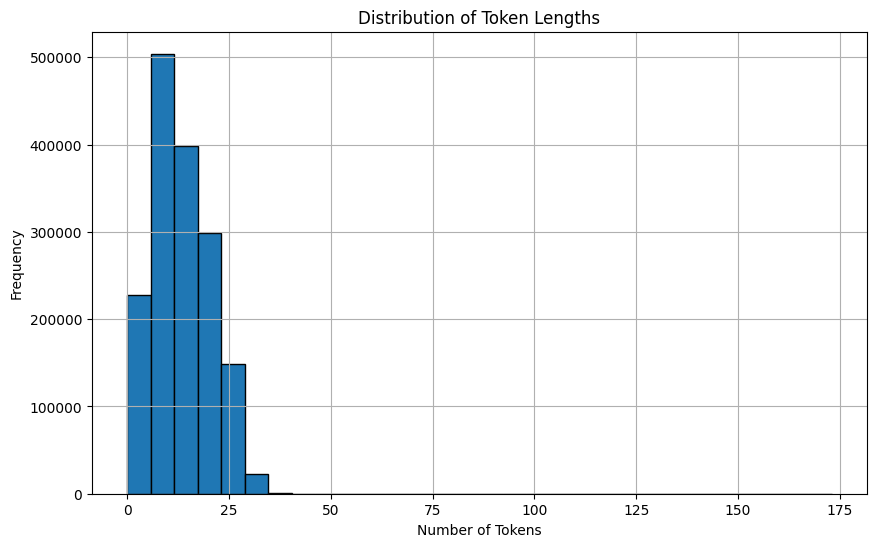

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'tokens' is the column containing lists of tokens

# Step 1: Calculate the length of each list of tokens
df['token_length'] = df['tokens'].apply(len)

# Step 2: Display summary statistics
print(df['token_length'].describe())

# Step 3: Plot a histogram to visualize the distribution of token lengths
plt.figure(figsize=(10, 6))
plt.hist(df['token_length'], bins=30, edgecolor='black')
plt.title('Distribution of Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Splitting the dataset
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=60000, oov_token="<unk>")
tokenizer.fit_on_texts(train_df["tokens"])

# Padding and truncating sequences
def preprocess_data(df, tokenizer, max_len=32):
    sequences = tokenizer.texts_to_sequences(df["tokens"])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    labels = df["sentiment"].values
    return padded_sequences, labels

train_sequences, train_labels = preprocess_data(train_df, tokenizer)
valid_sequences, valid_labels = preprocess_data(valid_df, tokenizer)
test_sequences, test_labels = preprocess_data(test_df, tokenizer)

In [ ]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels)).shuffle(len(train_sequences)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_sequences, valid_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels)).batch(batch_size)

In [ ]:
from tensorflow.keras import layers, Model

# Model definition using Functional API
def build_model(vocab_size, embedding_dim, hidden_size, max_len=32):
    inputs = tf.keras.Input(shape=(max_len,))

    # Embedding and Layer Normalization
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
    x = layers.LayerNormalization()(x)

    # Bidirectional LSTM layers (3 layers )
    x = layers.Bidirectional(layers.LSTM(hidden_size, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(hidden_size, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(hidden_size, return_sequences=False))(x)

    # Dropout
    x = layers.Dropout(0.5)(x)

    # Batch Normalization
    x = layers.BatchNormalization()(x)

    # Fully connected layer (without activation
    x = layers.Dense(hidden_size, use_bias=True)(x)

    # ReLU Activation (applied separately)
    x = layers.ReLU()(x)

    # Output layer (no activation, logits expected)
    outputs = layers.Dense(2)(x)

    model = Model(inputs, outputs)
    return model

# Model instantiation
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 128
hidden_size = 64

model = build_model(vocab_size, embedding_dim, hidden_size)

# Model compilation (optimizer and loss stay in FP32 to avoid numerical instability)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 32, 128)             │      75,492,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 32, 128)             │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,798,594 (289.15 MB)

 Trainable params: 75,798,338 (289.15 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
else:
    print("GPU is not available. Training will use the CPU.")

GPU is available and will be used for training.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Define a custom learning rate schedule function
def lr_scheduler(epoch, lr):
    return lr * 0.5  # Halve the learning rate after each epoch

# Callbacks for early stopping, model checkpoint, and custom learning rate scheduling
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Training the model
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=10,
                    callbacks=[checkpoint, lr_schedule, early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7969 - loss: 0.4401
Epoch 1: val_loss improved from inf to 0.38905, saving model to best_model.keras
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1128s 56ms/step - accuracy: 0.7969 - loss: 0.4401 - val_accuracy: 0.8210 - val_loss: 0.3890 - learning_rate: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.0024999999441206455.
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8383 - loss: 0.3671
Epoch 2: val_loss improved from 0.38905 to 0.36989, saving model to best_model.keras
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1134s 57ms/step - accuracy: 0.8383 - loss: 0.3671 - val_accuracy: 0.8328 - val_loss: 0.3699 - learning_rate: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.0012499999720603228.
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8516 - loss: 0.3379
Epoch 3: val_loss improv

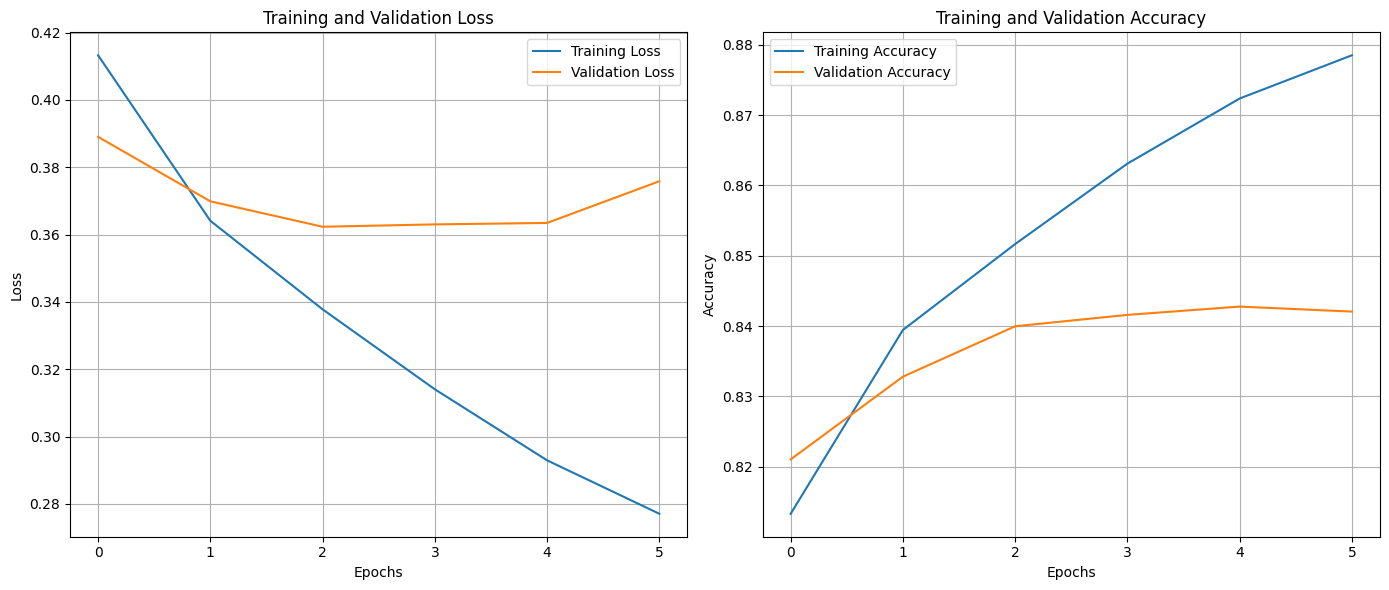

In [ ]:
import matplotlib.pyplot as plt

# Creating subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting the training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
best_model_path = "/content/drive/MyDrive/Colab Notebooks/Twitter Sentiment Analysis/best_model_60000_1.6M.keras"

# Load the best model before evaluation
model.load_weights(best_model_path)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 56 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step - accuracy: 0.8377 - loss: 0.3601
Test Loss: 0.3610, Test Accuracy: 0.8384


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step


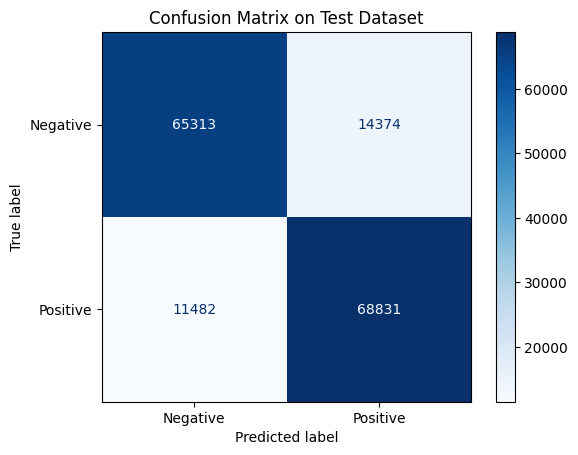

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions on the test dataset
test_predictions = model.predict(test_dataset)
test_predictions_labels = np.argmax(test_predictions, axis=1)

# Get the true labels from the test dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions_labels)

# Plotting the confusion matrix as percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Dataset')
plt.show()